In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy as cy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import s3fs
import intake
import warnings

In [66]:
def count_ARs(ds, lat_cut):
    '''
    Counts number of AR at each time step. Returns dataset with added coordinate ar_counts_[lat_cut].
    '''
    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))

    ar_counts = np.zeros(len(pole_ds.time))
    for i,ts in enumerate(pole_ds.time):
        ll = xr.plot.contour(pole_ds.sel(time=ts).ivt, levels=[0.0,1.0])
        plt.close()
        if len(ll.collections)>1: #You can remove this and next line if you have run it a few times without getting the printout :))
            print('julia was wrong about something, tell her to fix it'+ts) 
        nr_ar = len(ll.collections[0].get_paths())
        ar_counts[i] = nr_ar
    ds[f'ar_counts_{lat_cut}']= (['time'], ar_counts)
    return ds

def circle_for_polar_map(axes):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_boundary(circle, transform=axes.transAxes)
    
def sort_ar_by_aod(aod_ds,ar_ds, poll_lim, clean_lim):
    warnings.simplefilter('ignore', UserWarning)
    aod_ar=aod_ds.where(ar_ds.ivt==True)
    aod_ar['poll_ar_aod'] = xr.DataArray(coords=aod_ar.coords, dims =aod_ar.dims)
    aod_ar['clean_ar_aod'] = xr.DataArray(coords=aod_ar.coords, dims =aod_ar.dims)
    aod_ar['mid_ar_aod'] = xr.DataArray(coords=aod_ar.coords, dims =aod_ar.dims)
    clean_ar_counts = np.zeros(len(aod_ds.time))
    poll_ar_counts = np.zeros(len(aod_ds.time))
    mid_ar_counts = np.zeros(len(aod_ds.time))
    for i,ts in enumerate(aod_ar.time):
        ts_array = aod_ar.sel(time=ts).od550aer
        ll = xr.plot.contourf(ts_array.squeeze(), levels=[0,20])
        plt.close()
        ar_paths = ll.collections[0].get_paths()
        for j,item in enumerate(ar_paths):
            v = item.vertices
            lat = v[:,1]
            lon = v[:,0]
            ar_i_aod = ts_array.sel(lat=slice(np.min(lat), np.max(lat)), lon = slice(np.min(lon), np.max(lon)))
            
            if ar_i_aod.mean(skipna=True).values>poll_lim.values:
                aod_ar['poll_ar_aod'].loc[ts,slice(np.min(lat), np.max(lat)),slice(np.min(lon), np.max(lon))] = ar_i_aod
                poll_ar_counts[i]=poll_ar_counts[i]+1
            elif ar_i_aod.mean(skipna=True).values< clean_lim.values :
                aod_ar['clean_ar_aod'].loc[ts,slice(np.min(lat), np.max(lat)),slice(np.min(lon), np.max(lon))] = ar_i_aod
                clean_ar_counts[i]=clean_ar_counts[i]+1
            else:
                aod_ar['mid_ar_aod'].loc[ts,slice(np.min(lat), np.max(lat)),slice(np.min(lon), np.max(lon))] = ar_i_aod
                mid_ar_counts[i]=mid_ar_counts[i]+1
    aod_ar['clean_ar_counts']= (['time'], clean_ar_counts)
    aod_ar['mid_ar_counts']= (['time'], mid_ar_counts)
    aod_ar['poll_ar_counts']= (['time'], poll_ar_counts)
    return aod_ar

In [71]:
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
import matplotlib as mpl
import xarray as xr
import scipy.stats as st

distrib = st.mielke

params = [159.41596223491013, 26.727408136167004, -1.1915471684285064, 2.1257486429240604]
params_init =[25.958341361875725, 6.033654880661353, -0.03094463517841417, 0.0628311337711128]

def qm(tmax,fit_params_,fit_params_era5):
    k,s,loc,scale = fit_params_
    k_,s_,loc_,scale_ = fit_params_era5
    cdf_hist = distrib.cdf(tmax,*fit_params_)
    tmax_qm = distrib.ppf(cdf_hist,*fit_params_era5)
    return tmax_qm


def qdm(tmax):
    tqdm = np.zeros(np.shape(tmax))
    ntimes = np.shape(tqdm)[0]
    nlats = np.shape(tqdm)[1]
    nlons = np.shape(tqdm)[2]
    loc_qm = qm(tmax.flatten(),params,params_init)
    tqdm = loc_qm.reshape(ntimes,nlats,nlons)
    tqdm[np.isnan(tqdm)]=0
    tqdm[np.isinf(tqdm)]=0
    return tqdm



## Load data

In [7]:
start_year='2000'
end_year='2015'

Historical aod

In [8]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
#s3.ls('escience2022/Remy/')

In [9]:
s3path_hist1_aod = 's3://escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20000101-20091231.nc'
s3path_hist2_aod = 's3://escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20100101-20141231.nc'

hist1_aod = xr.open_dataset(s3.open(s3path_hist1_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])
hist2_aod = xr.open_dataset(s3.open(s3path_hist2_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])

aod_hist = xr.merge([hist1_aod, hist2_aod])

In [73]:
corrected_aod = qdm(aod_hist.od550aer.values)

In [75]:
aod_hist['od550aer'] = (['time','lat','lon'], corrected_aod)

Atmospheric river detection file

In [10]:
ar_hist = xr.open_dataset('20002015_AR_detection_counted.nc')

Variables

In [11]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [36]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['clt','pr','tas','hus'], member_id=['r1i1p1f1'])
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dataset_list = list(dset_dict.keys())
dset = dset_dict[dataset_list[0]]
hist_vars = dset.sel(member_id='r1i1p1f1',time=slice(str(start_year)+"-01-01", str(end_year)+"-01-01"))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## Calculating aod thresholds

[]

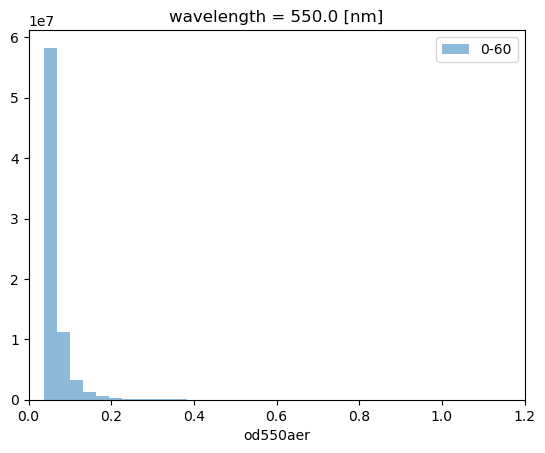

In [96]:
aod_hist.sel(lat = slice(-90,90)).od550aer.plot.hist(bins = 500,xlim = [0,1.2], label='0-60', alpha=0.5)
#aod_hist.sel(lat = slice(60,90)).od550aer.plot.hist(bins=100, xlim = [0,1.2], label='60-90', alpha=0.5)
#plt.axvline(aod_hist.sel(lat = slice(0,60)).od550aer.quantile(0.25))
#plt.yscale('log')
plt.legend()
plt.plot()

In [112]:
aod_lim= {}
aod_lim['arc_75th'] = aod_hist.sel(lat = slice(60,90)).od550aer.quantile(0.75,skipna=True)
aod_lim['arc_25th'] = aod_hist.sel(lat = slice(60,90)).od550aer.quantile(0.25,skipna=True)
aod_lim['arc_50th'] = aod_hist.sel(lat = slice(60,90)).od550aer.quantile(0.25,skipna=True)
aod_lim['arc_mean'] = aod_hist.sel(lat = slice(60,90)).od550aer.mean(skipna=True)
aod_lim['arc_median'] = aod_hist.sel(lat = slice(60,90)).od550aer.median(skipna=True)
aod_lim['midlat_mean'] = aod_hist.sel(lat = slice(0,60)).od550aer.mean(skipna=True)
aod_lim['midlat_75th'] = aod_hist.sel(lat = slice(30,60)).od550aer.quantile(0.75,skipna=True)
aod_lim['midlat_25th'] = aod_hist.sel(lat = slice(30,60)).od550aer.quantile(0.25,skipna=True)
aod_lim['midlowlat_75th'] = aod_hist.sel(lat = slice(-60,-30)).od550aer.quantile(0.75,skipna=True)
aod_lim['midlowlat_25th'] = aod_hist.sel(lat = slice(-60,-30)).od550aer.quantile(0.25,skipna=True)
aod_lim['midlat_90th'] = aod_hist.sel(lat = slice(0,60)).od550aer.quantile(0.9,skipna=True)

In [113]:
aod_ar_ds = sort_ar_by_aod(aod_hist.sel(lat=slice(60,90)), ar_hist.sel(lat=slice(60,90)), aod_lim['midlat_75th'], aod_lim['midlat_25th'])

In [114]:
plotting_vars = {}
flat_vars = ['clt','pr','tas','hus']
levs = ['clean','mid','poll']
#for var in vars:
for lev in levs:
    lev_dict = {}
    lev_dict['ar_masked'] = hist_vars.sel(lat=slice(60,90)).where(aod_ar_ds[f'{lev}_ar_aod'].notnull() )
    for var in flat_vars:    
        lev_dict[f'{var}_flat']= lev_dict['ar_masked'][var].values.flatten()[~np.isnan(lev_dict['ar_masked'][var].values.flatten())]
    plotting_vars[lev]=lev_dict
    

In [115]:
list(plotting_vars['clean'].keys())[1:]

['clt_flat', 'pr_flat', 'tas_flat', 'hus_flat']

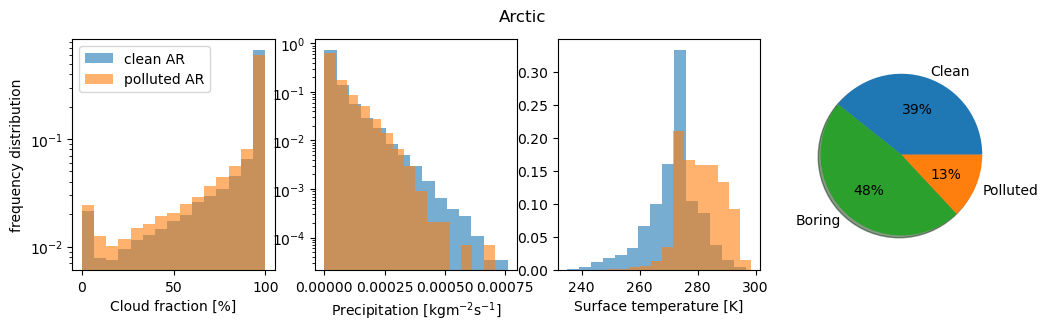

In [140]:
fig, axs = plt.subplots(1,len(list(plotting_vars['clean'].keys())[1:-1])+1, dpi=100, figsize=(12,3))

for i, var in enumerate(list(plotting_vars['clean'].keys())[1:-1]):
    axs[i].hist(plotting_vars['clean'][var], alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(plotting_vars['clean'][var]) + 1. / plotting_vars['clean'][var].size)
    axs[i].hist(plotting_vars['poll'][var], alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(plotting_vars['poll'][var]) + 1. / plotting_vars['poll'][var].size)

sum = aod_ar_ds.sum(dim='time')

axs[3].pie([sum[count] for count in ['clean_ar_counts','mid_ar_counts','poll_ar_counts']]
           ,labels = ['Clean','Boring','Polluted'], colors = ['tab:blue', 'tab:green','tab:orange'], autopct='%1.f%%',shadow=True)    
    
axs[0].set_xlabel('Cloud fraction [%]')
axs[0].set_ylabel('frequency distribution')
axs[1].set_xlabel('Precipitation [kgm$^{-2}$s$^{-1}$]')
axs[2].set_xlabel('Surface temperature [K]')
axs[2].set_xlabel('Surface temperature [K]')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
fig.suptitle('Arctic')
axs[0].legend()
plt.show()

In [117]:
ant_aod_ar_ds = sort_ar_by_aod(aod_hist.sel(lat=slice(-90,-60)), ar_hist.sel(lat=slice(-90,-60)), aod_lim['midlowlat_75th'], aod_lim['midlowlat_25th'])

In [118]:
ant_plotting_vars = {}
flat_vars = ['clt','pr','tas']
levs = ['clean','mid','poll']
#for var in vars:
for lev in levs:
    lev_dict = {}
    lev_dict['ar_masked'] = hist_vars.sel(lat=slice(-90,-60)).where(ant_aod_ar_ds[f'{lev}_ar_aod'].notnull() )
    for var in flat_vars:    
        lev_dict[f'{var}_flat']= lev_dict['ar_masked'][var].values.flatten()[~np.isnan(lev_dict['ar_masked'][var].values.flatten())]
    ant_plotting_vars[lev]=lev_dict

In [119]:
aod_lim['midlat_75th']

<xarray.DataArray 'od550aer' ()>
array(0.06565975)
Coordinates:
    quantile  float64 0.75

In [120]:
aod_lim['midlowlat_75th']

<xarray.DataArray 'od550aer' ()>
array(0.0795169)
Coordinates:
    quantile  float64 0.75

In [121]:
ant_aod_ar_ds.mid_ar_counts.sum()

<xarray.DataArray 'mid_ar_counts' ()>
array(973.)
Coordinates:
    wavelength  float64 550.0

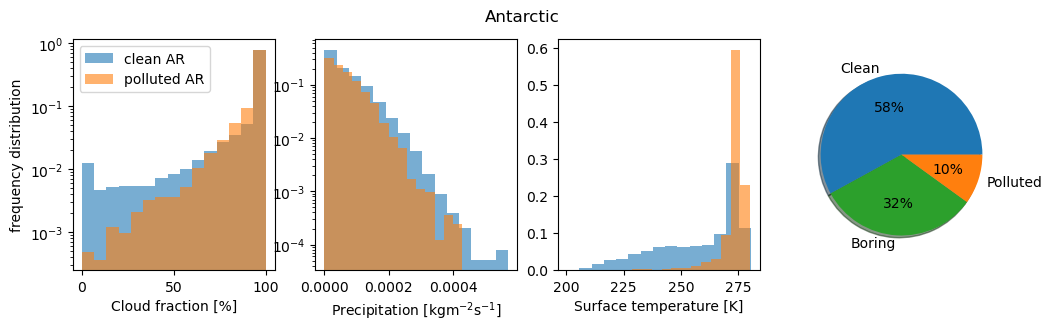

In [136]:
fig, axs = plt.subplots(1,len(list(ant_plotting_vars['clean'].keys())[1:])+1, dpi=100, figsize=(12,3))

for i, var in enumerate(list(ant_plotting_vars['clean'].keys())[1:]):
    axs[i].hist(ant_plotting_vars['clean'][var], alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(ant_plotting_vars['clean'][var]) + 1. / ant_plotting_vars['clean'][var].size)
    axs[i].hist(ant_plotting_vars['poll'][var], alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(ant_plotting_vars['poll'][var]) + 1. / ant_plotting_vars['poll'][var].size)

ant_sum = ant_aod_ar_ds.sum(dim='time')

axs[3].pie([ant_sum[count] for count in ['clean_ar_counts','mid_ar_counts','poll_ar_counts']]
           ,labels = ['Clean','Boring','Polluted'], colors = ['tab:blue', 'tab:green','tab:orange'], autopct='%1.f%%',shadow=True)
    
axs[0].set_xlabel('Cloud fraction [%]')
axs[0].set_ylabel('frequency distribution')
axs[1].set_xlabel('Precipitation [kgm$^{-2}$s$^{-1}$]')
axs[2].set_xlabel('Surface temperature [K]')
axs[2].set_xlabel('Surface temperature [K]')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
fig.suptitle('Antarctic')
axs[0].legend()
plt.show()

In [123]:
ant_sum = ant_aod_ar_ds.sum(dim='time')

([<matplotlib.patches.Wedge at 0x7f2cfe6c0b20>,
 [Text(-0.27305184009923356, 1.0655715333183515, 'Clean'),
  Text(-0.0687970173394553, -1.0978465149578946, 'Boring'),
  Text(1.0464080462241052, -0.3391610248797036, 'Polluted')])

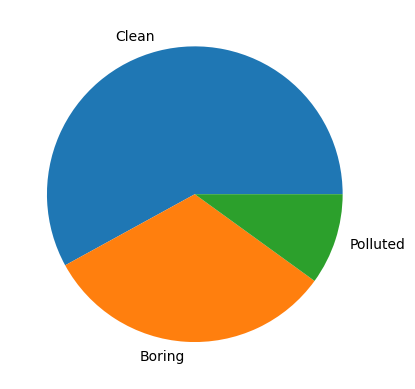

In [125]:
plt.pie([ant_sum['clean_ar_counts'],ant_sum['mid_ar_counts'],ant_sum['poll_ar_counts']], labels = ['Clean','Boring','Polluted'])

In [ ]:
hist_poll_ar = hist_vars.sel(lat=slice(60,90)).where(aod_ar_ds.poll_ar_aod.notnull() )
hist_clean_ar = hist_vars.sel(lat=slice(60,90)).where(aod_ar_ds.clean_ar_aod.notnull() )

In [113]:
clean_clt = hist_clean_ar.clt.values.flatten()[~np.isnan(hist_clean_ar.clt.values.flatten())]
poll_clt = hist_poll_ar.clt.values.flatten()[~np.isnan(hist_poll_ar.clt.values.flatten())]

In [114]:
clean_tas = hist_clean_ar.tas.values.flatten()[~np.isnan(hist_clean_ar.tas.values.flatten())]
poll_tas = hist_poll_ar.tas.values.flatten()[~np.isnan(hist_poll_ar.tas.values.flatten())]

In [115]:
clean_pr = hist_clean_ar.pr.values.flatten()[~np.isnan(hist_clean_ar.pr.values.flatten())]
poll_pr = hist_poll_ar.pr.values.flatten()[~np.isnan(hist_poll_ar.pr.values.flatten())]

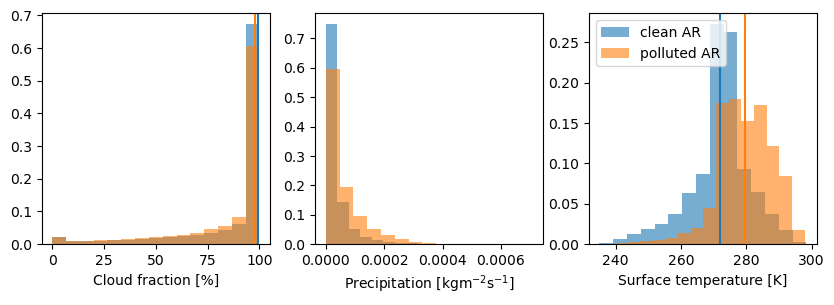

In [128]:
fig, axs = plt.subplots(1,3, dpi=100, figsize=(10,3))

axs[0].hist(clean_clt, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_clt) + 1. / clean_clt.size)
axs[0].hist(poll_clt,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_clt) + 1. / poll_clt.size)
axs[0].axvline(np.median(clean_clt), color= 'tab:blue')
axs[0].axvline(np.median(poll_clt), color= 'tab:orange')

axs[1].hist(clean_pr, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_pr) + 1. / clean_pr.size)
axs[1].hist(poll_pr,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_pr) + 1. / poll_pr.size)
#axs[1].axvline(np.mean(clean_pr), color= 'tab:blue')
#axs[1].axvline(np.mean(poll_pr), color= 'tab:orange')

axs[2].hist(clean_tas, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_tas) + 1. / clean_tas.size)
axs[2].hist(poll_tas,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_tas) + 1. / poll_tas.size)
axs[2].axvline(np.mean(clean_tas), color= 'tab:blue')
axs[2].axvline(np.mean(poll_tas), color= 'tab:orange')

axs[0].set_xlabel('Cloud fraction [%]')
axs[1].set_xlabel('Precipitation [kgm$^{-2}$s$^{-1}$]')
axs[2].set_xlabel('Surface temperature [K]')

#axs[0].set_yscale('log')
#axs[1].set_yscale('log')
plt.legend()
plt.show()

In [ ]:
#Seasonal plot
#add hus?
#change precip values
#animate 1 year and color by aod or temp?
#AR anomaly map plots?